In [ ]:
# 合并数据

In [1]:
import pandas as pd

# 文件路径
years = range(2013, 2024)
file_paths = [f"H:/项目/制作中/投资组合与因子建模/完整过程1/output/returns_updated_策略15_{year}.xlsx" for year in years]
annual_returns_dfs = []

# 读取每一年的数据，计算年度收益
for file_path in file_paths:
    data = pd.read_excel(file_path)
    melted_data = pd.melt(
        data,
        id_vars=['证券代码', '年份', '策略'],
        var_name='日期',
        value_name='收益'
    )
    # 转换“收益”列为浮点数类型
    melted_data['收益'] = pd.to_numeric(melted_data['收益'], errors='coerce')
    
    # 删除无法转换为数字的值
    melted_data = melted_data.dropna(subset=['收益'])
    
    melted_data.reset_index(drop=True, inplace=True)
    annual_returns = melted_data.groupby(['证券代码', '年份', '策略'])['收益'].sum().reset_index()
    annual_returns_dfs.append(annual_returns)

# 合并所有年份的年度收益数据
all_annual_returns = pd.concat(annual_returns_dfs, ignore_index=True)

# 保存合并后的年度收益数据到Excel文件
annual_returns_output_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/all_annual_returns_策略15.xlsx"
all_annual_returns.to_excel(annual_returns_output_path, index=False)

# 读取新的数据
new_data_path = "H:/项目/制作中/投资组合与因子建模/完整框架/筛选因子修正后.xlsx"
new_data = pd.read_excel(new_data_path)

# 合并数据，保留年度收益数据和新的公司市值、增长率、波动性、股息率
merged_data = pd.merge(
    all_annual_returns,
    new_data[['证券代码', '年份', '公司市值', '增长率', '波动性', '股息率']],
    on=['证券代码', '年份'],
    how='left'
)

# 保存合并后的数据到新的Excel文件
merged_data_output_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/merged_data_with_factors_all_years.xlsx"
merged_data.to_excel(merged_data_output_path, index=False)


F:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-e793117c380c>:32: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  all_annual_returns.to_excel(annual_returns_output_path, index=False)
<ipython-input-1-e793117c380c>:48: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  merged_data.to_excel(merged_data_output_path, index=False)


In [ ]:
#原始因子重要性

均方误差: 0.14444584696817234
R²分数: -0.03042660635481287


<ipython-input-2-1e7e65ace38e>:53: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  feature_importances.to_excel(importance_path)


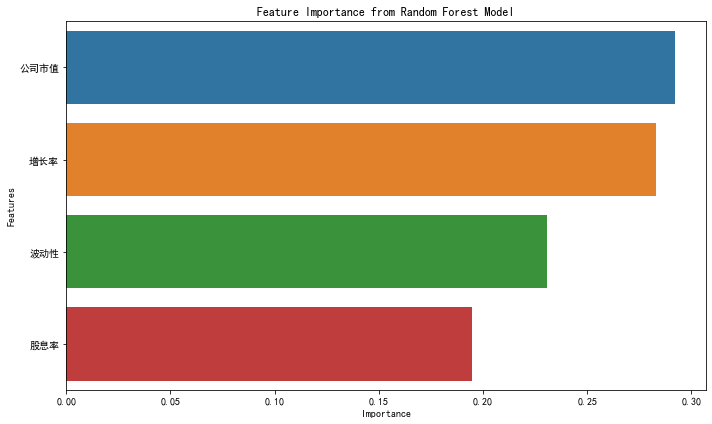

特征重要性可视化图已保存到: H:/项目/制作中/投资组合与因子建模/完整框架/归因/feature_importances_plot.png


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # 用于保存模型
import matplotlib.pyplot as plt
import seaborn as sns

# 文件路径
file_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/merged_data_with_factors_all_years.xlsx"

# 读取数据
data = pd.read_excel(file_path)

# 转换数据类型为数值型 (如果必要)
data['公司市值'] = pd.to_numeric(data['公司市值'], errors='coerce')
data['增长率'] = pd.to_numeric(data['增长率'], errors='coerce')
data['波动性'] = pd.to_numeric(data['波动性'], errors='coerce')
data['股息率'] = pd.to_numeric(data['股息率'], errors='coerce')
data['收益'] = pd.to_numeric(data['收益'], errors='coerce')

# 去除缺失值
data = data.dropna(subset=['公司市值', '增长率', '波动性', '股息率', '收益'])

# 准备数据
X = data[['公司市值', '增长率', '波动性', '股息率']]
y = data['收益']

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化和训练随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差: {mse}")
print(f"R²分数: {r2}")

# 保存模型
model_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/random_forest_model.pkl"
joblib.dump(model, model_path)

# 保存特征重要性
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance'])
importance_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/feature_importances.xlsx"
feature_importances.to_excel(importance_path)

# 特征重要性可视化
plt.figure(figsize=(10, 6))
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体显示中文
sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()

# 保存可视化图
plt_path = "H:/项目/制作中/投资组合与因子建模/完整框架/归因/feature_importances_plot.png"
plt.savefig(plt_path)

plt.show()

print(f"特征重要性可视化图已保存到: {plt_path}")


In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 读取数据
df = pd.read_csv('H:/项目/制作中/投资组合与因子建模/因子建模/完整因子.csv')

# 对数转换（使用 ln(x + 1)）
columns_to_log_transform = ['公司市值', '波动性', '股息率',]

for column in columns_to_log_transform:
    if column in df.columns:
        df[f'Log_{column}'] = np.log(df[column] + 1)

# 将 inf 替换为均值
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()


# 自变量与因变量
X = df_cleaned[['Log_公司市值',  'Log_波动性', 'Log_股息率']]
Y_drawdown = df_cleaned['收益']

# 添加截距项
X = sm.add_constant(X)

# 分割数据集为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_drawdown, test_size=0.3, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 确保标准化后的 DataFrame 具有相同的索引
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# 使用 statsmodels 进行回归分析
model = sm.OLS(Y_train, X_train_scaled)
results = model.fit()

# 输出回归结果，包括回归参数、标准误、t值、p值等
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                     收益   R-squared (uncentered):                   0.115
Model:                            OLS   Adj. R-squared (uncentered):              0.109
Method:                 Least Squares   F-statistic:                              20.29
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                    2.23e-12
Time:                        10:09:12   Log-Likelihood:                         -149.93
No. Observations:                 473   AIC:                                      305.9
Df Residuals:                     470   BIC:                                      318.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

F:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
#计算回撤并将回撤加入模型

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# 读取数据
df = pd.read_csv('H:/项目/制作中/投资组合与因子建模/因子建模/完整因子.csv')

# 重命名变量为英文
df = df.rename(columns={
    '公司市值': 'Market_Cap',
    '增长率': 'Growth_Rate',
    '波动性': 'Volatility',
    '股息率': 'Dividend_Yield',
    '年个股交易股数': 'Annual_Stock_Trading_Volume',
    '市盈率': 'PE_Ratio',
    '市销率': 'PS_Ratio',
    '市现率': 'PCF_Ratio',
    '市净率': 'PB_Ratio',
    '市值有形资产比': 'Market_Value_to_Tangible_Assets_Ratio',
    '托宾Q值': 'Tobin_Q',
    '账面市值比': 'Book_to_Market_Ratio',
    '净资产收益率': 'ROE',
    '资产负债率': 'Debt_to_Assets_Ratio',
    '收益': 'Returns'
})

# 对数转换（使用 ln(x + 1)）
columns_to_log_transform = ['Market_Cap', 'Growth_Rate', 'Volatility', 'Dividend_Yield', 'Annual_Stock_Trading_Volume', 
                             'PE_Ratio', 'PS_Ratio', 'PCF_Ratio', 'PB_Ratio', 
                             'Market_Value_to_Tangible_Assets_Ratio', 'Tobin_Q', 'Book_to_Market_Ratio', 'ROE', 
                             'Debt_to_Assets_Ratio']

for column in columns_to_log_transform:
    if column in df.columns:
        df[f'Log_{column}'] = np.log(df[column] + 1)

# 将 inf 替换为均值
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()

# 计算累积收益
df_cleaned['Cumulative_Returns'] = (1 + df_cleaned['Returns']).cumprod()

# 计算滚动最大值
df_cleaned['Rolling_Max'] = df_cleaned['Cumulative_Returns'].cummax()

# 计算回撤
df_cleaned['Drawdown'] = (df_cleaned['Cumulative_Returns'] - df_cleaned['Rolling_Max']) / df_cleaned['Rolling_Max']

# 计算最大回撤
max_drawdown = df_cleaned['Drawdown'].min()
print(f"Max Drawdown: {max_drawdown:.2%}")

# 自变量与因变量
X = df_cleaned[['Log_Market_Cap', 'Log_Growth_Rate', 'Log_Volatility', 'Log_Dividend_Yield', 
                'Log_Annual_Stock_Trading_Volume', 'Log_PE_Ratio', 'Log_PS_Ratio', 'Log_PCF_Ratio', 
                'Log_PB_Ratio', 'Log_Market_Value_to_Tangible_Assets_Ratio', 'Log_Tobin_Q', 
                'Log_Book_to_Market_Ratio', 'Log_ROE', 'Log_Debt_to_Assets_Ratio']]

Y_drawdown = df_cleaned['Drawdown']

# 分割数据集为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_drawdown, test_size=0.3, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建并训练随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 网格搜索调整参数
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# 最佳参数和模型
best_rf_model = grid_search.best_estimator_

# 预测回撤
Y_pred = best_rf_model.predict(X_test_scaled)

# 计算模型性能
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error after tuning: {mse}")
print(f"R^2 Score after tuning: {r2}")

# 将预测的最大回撤作为新的自变量
df_cleaned['Predicted_Drawdown'] = best_rf_model.predict(scaler.transform(X))

# 用预测回撤预测收益
Y = df_cleaned['Returns']
X_new = df_cleaned[['Predicted_Drawdown']]

# 分割数据集为训练集和测试集
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_new, Y, test_size=0.3, random_state=42)

# 标准化
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

# 创建并训练模型
rf_model_new = RandomForestRegressor(random_state=42)
rf_model_new.fit(X_train_scaled_new, Y_train_new)

# 预测收益
Y_pred_new = rf_model_new.predict(X_test_scaled_new)

# 计算模型性能
mse_new = mean_squared_error(Y_test_new, Y_pred_new)
r2_new = r2_score(Y_test_new, Y_pred_new)

print(f"Mean Squared Error for Returns Prediction: {mse_new}")
print(f"R^2 Score for Returns Prediction: {r2_new}")


F:\anaconda\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\anaconda\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Max Drawdown: -88.27%
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mean Squared Error after tuning: 0.03720384924305537
R^2 Score after tuning: 0.3446363790293603
Mean Squared Error for Returns Prediction: 0.07328542916579799
R^2 Score for Returns Prediction: 0.03956203874127662


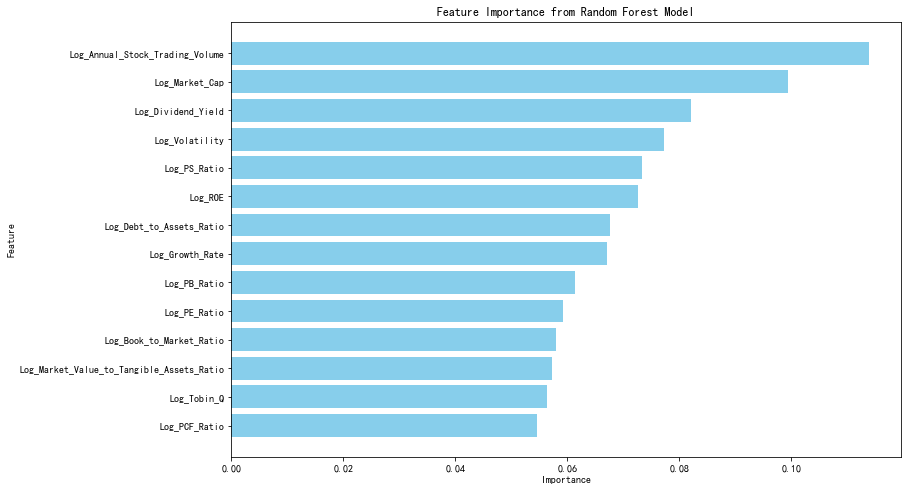

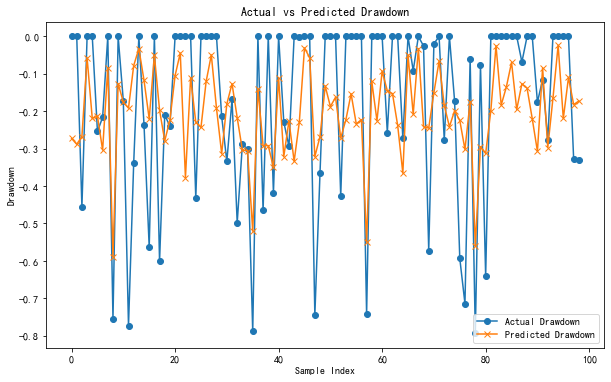

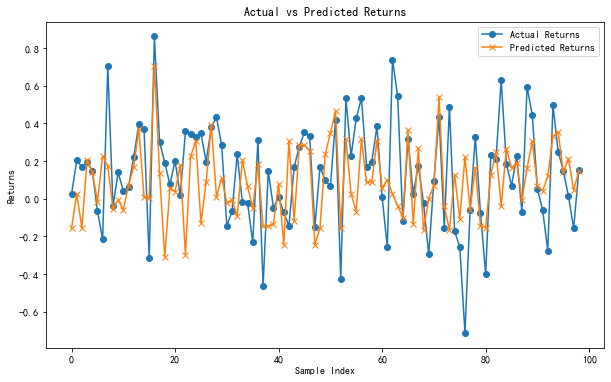

In [35]:
# 可视化：特征重要性
import matplotlib.pyplot as plt

# 获取最佳模型的特征重要性
importances = best_rf_model.feature_importances_
features = X.columns

# 创建特征重要性数据框并排序
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # 反转y轴，使得最重要的特征在顶部
plt.show()

# 可视化：实际 vs 预测 回撤
plt.figure(figsize=(10, 6))
plt.plot(Y_test.values, label='Actual Drawdown', marker='o')
plt.plot(Y_pred, label='Predicted Drawdown', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Drawdown')
plt.title('Actual vs Predicted Drawdown')
plt.legend()
plt.show()

# 可视化：实际 vs 预测 收益
plt.figure(figsize=(10, 6))
plt.plot(Y_test_new.values, label='Actual Returns', marker='o')
plt.plot(Y_pred_new, label='Predicted Returns', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Returns')
plt.title('Actual vs Predicted Returns')
plt.legend()
plt.show()


In [62]:
import os
import pandas as pd

# 读取 CSV 文件
file_path = r"H:\项目\制作中\投资组合与因子建模\因子建模\增加因子.xlsx"
data = pd.read_excel(file_path)  # 使用 pd.read_csv

# 数据类型转换：确保数值列为数值类型
data['公司市值'] = pd.to_numeric(data['公司市值'], errors='coerce')
data['增长率'] = pd.to_numeric(data['增长率'], errors='coerce')
data['波动性'] = pd.to_numeric(data['波动性'], errors='coerce')
data['股息率'] = pd.to_numeric(data['股息率'], errors='coerce')
data['年个股交易股数'] = pd.to_numeric(data['年个股交易股数'], errors='coerce')

# 检查并输出缺失因子列的信息
missing_factors_summary = data[['公司市值', '增长率', '波动性', '股息率', '年个股交易股数']].isnull().sum()
if missing_factors_summary.any():
    print("数据中存在缺失值，具体缺失情况如下：")
    for factor, count in missing_factors_summary.items():
        if count > 0:
            print(f"{factor}: 缺失 {count} 条记录")
    
    # 删除含有缺失因子的记录
    data = data.dropna(subset=['公司市值', '增长率', '波动性', '股息率', '年个股交易股数'])
    print("缺失因子的记录已被删除。")
else:
    print("数据中没有缺失值。")

# 定义策略函数
def select_stocks(data, year, strategy_num):
    yearly_data = data[data['年份'] == year]
    
    if strategy_num == 1:
        selected = yearly_data.nsmallest(len(yearly_data) // 2, '公司市值')
    elif strategy_num == 2:
        selected = yearly_data.nlargest(len(yearly_data) // 2, '公司市值')
    elif strategy_num == 3:
        selected = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
    elif strategy_num == 4:
        selected = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
    elif strategy_num == 5:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 6:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 7:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 8:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 9:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '增长率')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 10:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '增长率')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 11:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '增长率')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 12:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '增长率')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 13:
        temp = yearly_data.nsmallest(len(yearly_data) // 2, '公司市值')
        temp = temp.nsmallest(int(len(temp) * 0.2), '波动性')
        selected = temp.nlargest(int(len(temp) * 0.2), '增长率')
    elif strategy_num == 14:
        temp = yearly_data.nsmallest(len(yearly_data) // 2, '公司市值')
        temp = temp.nlargest(int(len(temp) * 0.2), '增长率')
        selected = temp.nsmallest(int(len(temp) * 0.2), '波动性')
    elif strategy_num == 15:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 16:
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 17:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        selected = temp.nsmallest(len(temp) // 2, '公司市值')
    elif strategy_num == 18:
        temp = yearly_data.nlargest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        selected = temp.nlargest(len(temp) // 2, '公司市值')
    elif strategy_num == 19:
        temp = yearly_data.nsmallest(len(yearly_data) // 2, '公司市值')
        temp = temp.nsmallest(int(len(temp) * 0.2), '波动性')
        selected = temp.nlargest(int(len(temp) * 0.2), '股息率')
    elif strategy_num == 20:
        temp = yearly_data.nsmallest(len(yearly_data) // 2, '公司市值')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        selected = temp.nsmallest(int(len(temp) * 0.2), '波动性')
    elif strategy_num == 21:
        # 新策略21：按波动性最小的20%，股息率最高的20%，市值最小的50%，再按年个股交易股数前50%
        temp = yearly_data.nsmallest(int(len(yearly_data) * 0.2), '波动性')
        temp = temp.nlargest(int(len(temp) * 0.2), '股息率')
        temp = temp.nsmallest(int(len(temp) * 0.5), '公司市值')
        temp = temp.nlargest(int(len(temp) * 0.5), '年个股交易股数')
        selected = temp
    else:
        selected = pd.DataFrame()  # 若策略号不匹配，则返回空数据框

    return selected[['证券代码',  '年份']]

# 筛选每年和每种策略下的股票代码
years = data['年份'].unique()
strategy_count = 21  # 更新策略数目

# 创建文件夹并保存
output_dir = "H:\\项目\\制作中\\投资组合与因子建模\\因子建模"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for strategy_num in range(1, strategy_count + 1):
    strategy_folder = os.path.join(output_dir, f"{strategy_num}")
    if not os.path.exists(strategy_folder):
        os.makedirs(strategy_folder)

    # 创建ExcelWriter对象
    output_path = os.path.join(strategy_folder, f"策略{strategy_num}.xlsx")
    with pd.ExcelWriter(output_path) as writer:
        for year in years:
            selected_stocks = select_stocks(data, year, strategy_num)
            selected_stocks.to_excel(writer, sheet_name=str(year), index=False)
    
    print(f"策略 {strategy_num} 的所有年份股票代码已保存至 {output_path}")


数据中存在缺失值，具体缺失情况如下：
公司市值: 缺失 2719 条记录
增长率: 缺失 62 条记录
波动性: 缺失 2858 条记录
股息率: 缺失 7615 条记录
缺失因子的记录已被删除。


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 1 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\1\策略1.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 2 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\2\策略2.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 3 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\3\策略3.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 4 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\4\策略4.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 5 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\5\策略5.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 6 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\6\策略6.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 7 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\7\策略7.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 8 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\8\策略8.xlsx
策略 9 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\9\策略9.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 10 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\10\策略10.xlsx
策略 11 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\11\策略11.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 12 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\12\策略12.xlsx
策略 13 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\13\策略13.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 14 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\14\策略14.xlsx
策略 15 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\15\策略15.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 16 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\16\策略16.xlsx
策略 17 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\17\策略17.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 18 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\18\策略18.xlsx
策略 19 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\19\策略19.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:


策略 20 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\20\策略20.xlsx
策略 21 的所有年份股票代码已保存至 H:\项目\制作中\投资组合与因子建模\因子建模\21\策略21.xlsx


<ipython-input-62-ff73bc4122e6>:129: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  with pd.ExcelWriter(output_path) as writer:
